# Encoding, Transforming and Scaling Features

We will cover the following topics in this chapter:
- creating training datasets and avoiding deep leakage
- identifying irrelevant or redundant observations to be removed
- encoding categorical features
- encoding features with medium or high cardinality
- transforming features
- binning features
- scaling features

## Create training datasets and avoiding data leakage

**Data leakage** occurs whenever our models are informed by data that is not in the training dataset. 


For example, if we have missing values for a feature, we might impute the mean across the whole dataset for those values. However, in order to validate our model, we subsequently split our data into training and testing data. We would have then accidentally introduced data leakage into our training dataset since the information from the full dataset (that is, global mean) would have been used.

## Removing redundant or unhelpful features

In [1]:
!pip install -qq feature-engine

In [7]:
import feature_engine.selection as fesel
from sklearn.model_selection import train_test_split

from data.load import load_ltpoland, load_nls97b

In [8]:
nls97 = load_nls97b()
ltpoland = load_ltpoland()

In [9]:
feature_cols = [
    "satverbal",
    "satmath",
    "gpascience",
    "gpaenglish",
    "gpamath",
    "gpaoverall",
]
X_train, X_test, y_train, y_test = train_test_split(
    nls97[feature_cols], nls97[["wageincome"]], test_size=0.3, random_state=0
)

In [10]:
X_train.corr()

,satverbal,satmath,gpascience,gpaenglish,gpamath,gpaoverall
satverbal,1.000000,0.728890,0.438588,0.443692,0.375226,0.420707
satmath,0.728890,1.000000,0.479757,0.430359,0.517770,0.484701
gpascience,0.438588,0.479757,1.000000,0.671744,0.606340,0.792695
gpaenglish,0.443692,0.430359,0.671744,1.000000,0.599713,0.843816
gpamath,0.375226,0.517770,0.606340,0.599713,1.000000,0.750494
gpaoverall,0.420707,0.484701,0.792695,0.843816,0.750494,1.000000


^ Here, `gpaoverall` is highly correlated with `gpascience`, `gpaenglish` and `gpamath`. 

The `corr` method returns the `Pearson` coefficients by default. This is fine when we can assume a linear relationship with the features. However, when this assumption does not make sense, we should consider requesting `Spearman` coefficients instead. 

Let's drop features that have a correlation higher than 0.75 with another feature.

In [11]:
tr = fesel.DropCorrelatedFeatures(variables=None, method="pearson", threshold=0.75)
tr.fit(X_train)
X_train_tr = tr.transform(X_train)
X_test_tr = tr.transform(X_test)
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6288 entries, 574974 to 370933
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   satverbal   1001 non-null   float64
 1   satmath     1001 non-null   float64
 2   gpascience  3998 non-null   float64
 3   gpaenglish  4078 non-null   float64
 4   gpamath     4056 non-null   float64
dtypes: float64(5)
memory usage: 294.8 KB


^ The column `gpaoverall` is dropped.

In [12]:
feature_cols = [
    "year",
    "month",
    "latabs",
    "latitude",
    "elevation",
    "longitude",
    "country",
]
X_train, X_test, y_train, y_test = train_test_split(
    ltpoland[feature_cols], ltpoland[["temperature"]], test_size=0.3, random_state=0
)

In [13]:
X_train.sample(5, random_state=99)

,year,month,latabs,latitude,elevation,longitude,country
station,,,,,,,
SIEDLCE,2019,11,52.250,52.250,152.0,22.250,Poland
OKECIE,2019,6,52.166,52.166,110.3,20.967,Poland
BALICE,2019,1,50.078,50.078,241.1,19.785,Poland
BALICE,2019,7,50.078,50.078,241.1,19.785,Poland
BIALYSTOK,2019,11,53.100,53.100,151.0,23.167,Poland


In [14]:
X_train.year.value_counts()

2019    84
Name: year, dtype: int64

In [15]:
X_train.country.value_counts()

Poland    84
Name: country, dtype: int64

In [16]:
(X_train.latitude != X_train.latabs).sum()

0

In [17]:
tr = fesel.DropConstantFeatures()
tr.fit(X_train)
X_train_tr = tr.transform(X_train)
X_test_tr = tr.transform(X_test)
X_train_tr.head()

,month,latabs,latitude,elevation,longitude
station,,,,,
OKECIE,1,52.166,52.166,110.3,20.9670
LAWICA,8,52.421,52.421,93.9,16.8260
LEBA,11,54.750,54.750,2.0,17.5331
SIEDLCE,10,52.250,52.250,152.0,22.2500
BIALYSTOK,11,53.100,53.100,151.0,23.1670


^ The feature `country` and `year` has been dropped.

In [18]:
tr = fesel.DropDuplicateFeatures()
tr.fit(X_train_tr)
X_train_tr = tr.transform(X_train_tr)
X_train_tr.head()

,month,latabs,elevation,longitude
station,,,,
OKECIE,1,52.166,110.3,20.9670
LAWICA,8,52.421,93.9,16.8260
LEBA,11,54.750,2.0,17.5331
SIEDLCE,10,52.250,152.0,22.2500
BIALYSTOK,11,53.100,151.0,23.1670


^ Features that have the same values as other features are dropped. In this case, the transform drop `latitude`, which has the same values as `latabs`.

## Encoding categorical features

### One-hot encoding

One-hot encoding a features creates a binary vector for each value of that feature.

In [3]:
import pandas as pd
from feature_engine.encoding import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from data.load import load_nls97b

In [4]:
nls97 = load_nls97b()

In [5]:
feature_cols = ["gender", "maritalstatus", "colenroct99"]
nls97_demo = nls97[["wageincome"] + feature_cols].dropna()

X_demo_train, X_demo_test, y_demo_train, y_demo_test = train_test_split(
    nls97_demo[feature_cols], nls97_demo[["wageincome"]], test_size=0.3, random_state=0
)

In [68]:
pd.get_dummies(X_demo_train, columns=["gender", "maritalstatus"]).head(2).T

personid,736081,832734
colenroct99,1. Not enrolled,1. Not enrolled
gender_Female,1,0
gender_Male,0,1
maritalstatus_Divorced,0,0
maritalstatus_Married,1,0
maritalstatus_Never-married,0,1
maritalstatus_Separated,0,0
maritalstatus_Widowed,0,0


Typically, we create `k-1` dummy variables for `k` unique values for a feature.

In [7]:
pd.get_dummies(X_demo_train, columns=["gender", "maritalstatus"], drop_first=True).head(
    2
).T

personid,736081,832734
colenroct99,1. Not enrolled,1. Not enrolled
gender_Male,0,1
maritalstatus_Married,1,0
maritalstatus_Never-married,0,1
maritalstatus_Separated,0,0
maritalstatus_Widowed,0,0


In [8]:
ohe = OneHotEncoder(drop_last=True, variables=["gender", "maritalstatus"])
ohe.fit(X_demo_train)

X_demo_train_ohe = ohe.transform(X_demo_train)
X_demo_test_ohe = ohe.transform(X_demo_test)
X_demo_train_ohe.filter(regex="gen|mar", axis="columns").head(2).T

personid,736081,832734
gender_Female,1,0
maritalstatus_Married,1,0
maritalstatus_Never-married,0,1
maritalstatus_Divorced,0,0
maritalstatus_Separated,0,0


In [36]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [61]:
columns = ["gender", "maritalstatus"]
ohe = OneHotEncoder(drop="first")
ohe.fit(X_demo_train[columns])

X_demo_train_ohe = ohe.transform(X_demo_train[columns])
X_demo_train_ohe = pd.DataFrame(
    X_demo_train_ohe.toarray(),
    columns=ohe.get_feature_names_out(),
    index=X_demo_train.index,
)
X_demo_train_ohe.filter(regex="gen|mar", axis="columns").head(2).T

personid,736081,832734
gender_Male,0.0,1.0
maritalstatus_Married,1.0,0.0
maritalstatus_Never-married,0.0,1.0
maritalstatus_Separated,0.0,0.0
maritalstatus_Widowed,0.0,0.0


A better option is to use `ColumnTransformer` to transform perform one hot encoding on selected columns.

In [66]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ["gender", "maritalstatus"]),
    remainder="passthrough",
    verbose_feature_names_out=False,  # Prevent prefixing columns with `onehotencoder_` and `remainder_`.
)
transformed = transformer.fit_transform(X_demo_train)
pd.DataFrame(
    transformed, columns=transformer.get_feature_names_out(), index=X_demo_train.index
)

,gender_Female,gender_Male,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Never-married,maritalstatus_Separated,maritalstatus_Widowed,colenroct99
personid,,,,,,,,
736081,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1. Not enrolled
832734,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1. Not enrolled
453537,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1. Not enrolled
322059,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1. Not enrolled
324323,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2. 2-year college
...,...,...,...,...,...,...,...,...
975681,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1. Not enrolled
686050,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1. Not enrolled
393058,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1. Not enrolled


### Summary

One-hot encoding is a fairly straightforward way to prepare nominal data for a machine learning algorithm.

## Ordinal encoding

Categorical features can be either nominal or ordinal. Gender and marital status are norminal. Their values do not imply order.

However, when a categorical feature is ordinal, we want the encoding to capture the ranking of the values. One-hot encoding will lose this ordering.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from data.load import load_nls97b

nls97 = load_nls97b()
feature_cols = ["gender", "maritalstatus", "colenroct99"]
nls97_demo = nls97[["wageincome"] + feature_cols].dropna()

X_demo_train, X_demo_test, y_demo_train, y_demo_test = train_test_split(
    nls97_demo[feature_cols], nls97_demo[["wageincome"]], test_size=0.3, random_state=0
)

The college enrollment for October 1999 can be considered an ordinal feature. The values are string, but there is an implied order.

In [71]:
X_demo_train.colenroct99.unique()

array(['1. Not enrolled', '2. 2-year college ', '3. 4-year college'],
      dtype=object)

In [73]:
X_demo_train.head()

,gender,maritalstatus,colenroct99
personid,,,
736081,Female,Married,1. Not enrolled
832734,Male,Never-married,1. Not enrolled
453537,Male,Married,1. Not enrolled
322059,Female,Divorced,1. Not enrolled
324323,Female,Married,2. 2-year college


In [75]:
oe = OrdinalEncoder(categories=[X_demo_train.colenroct99.unique()])
colenr_enc = pd.DataFrame(
    oe.fit_transform(X_demo_train[["colenroct99"]]),
    columns=["colenroct99"],
    index=X_demo_train.index,
)
colenr_enc

,colenroct99
personid,
736081,0.0
832734,0.0
453537,0.0
322059,0.0
324323,1.0
...,...
975681,0.0
686050,0.0
393058,0.0


In [77]:
X_demo_train_enc = X_demo_train[["gender", "maritalstatus"]].join(colenr_enc)
X_demo_train_enc

,gender,maritalstatus,colenroct99
personid,,,
736081,Female,Married,0.0
832734,Male,Never-married,0.0
453537,Male,Married,0.0
322059,Female,Divorced,0.0
324323,Female,Married,1.0
...,...,...,...
975681,Male,Married,0.0
686050,Female,Never-married,0.0
393058,Male,Married,0.0


In [78]:
X_demo_train.colenroct99.value_counts().sort_index()

1. Not enrolled       3050
2. 2-year college      142
3. 4-year college      350
Name: colenroct99, dtype: int64

In [79]:
X_demo_train_enc.colenroct99.value_counts().sort_index()

0.0    3050
1.0     142
2.0     350
Name: colenroct99, dtype: int64

### Summary

The ordinal encoding replaces the initial values for `colenroct99` with numbers from 0 to 2. 

> Note: Ordinal encoding is appropriate for non-linear models such as decision trees. It might not make sense in a linear regression model because that would assume that the distance between values was equally meaningful across the whole distribution.

## Encoding categorical features with medium or high cardinality


It can be impractical to create a dummy variable for each value when working with a categorical feature that has many unique values. 

There are couple of ways to handle medium or high cardinality:
- create dummies for the top k categories and group the remaining into an _other_ category
- use feature hashing

In [83]:
!pip install -qq category_encoders
import pandas as pd
from category_encoders.hashing import HashingEncoder
from feature_engine.encoding import OneHotEncoder
from sklearn.model_selection import train_test_split

from data.load import load_covid

In [85]:
covid = load_covid()
feature_cols = [
    "location",
    "population",
    "aged_65_older",
    "diabetes_prevalence",
    "region",
]
covid = covid[["total_cases"] + feature_cols].dropna()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    covid[feature_cols], covid[["total_cases"]], test_size=0.3, random_state=0
)

The feature `region` has 16 unique values.

In [89]:
X_train.region.value_counts()

Eastern Europe     16
East Asia          12
Western Europe     12
West Africa        11
West Asia          10
East Africa        10
South Asia          7
Southern Africa     7
South America       7
Central Africa      7
Oceania / Aus       6
Caribbean           6
Central Asia        5
North Africa        4
Central America     3
North America       3
Name: region, dtype: int64

We use the `OneHotEncoder` module from `feature_engine` to encode the `region` feature. This time, we use the `top_categories` parameter to indicate that we only want to create dummmies for the top six category values. Any values that do not fall into the top six will have a 0 for all of the dummies.

In [90]:
ohe = OneHotEncoder(top_categories=6, variables=["region"])
covid_ohe = ohe.fit_transform(covid)
covid_ohe.filter(regex="location|region", axis="columns").sample(5, random_state=99).T

iso_code,ISR,SEN,IDN,LKA,KEN
location,Israel,Senegal,Indonesia,Sri Lanka,Kenya
region_Eastern Europe,0,0,0,0,0
region_Western Europe,0,0,0,0,0
region_West Africa,0,1,0,0,0
region_East Asia,0,0,1,0,0
region_West Asia,1,0,0,0,0
region_East Africa,0,0,0,0,1


An alternative approach to one-hot encoding, when a _categorical feature_ has many unique values, is to use __feature hashing__.

### Feature Hashing

Feature hashing maps a large number of unique feature values to a smaller number of dummy variables. We can specify the number of dummy variables to create. However, collisions are possible; that is, some feature values might map to the same dummy variable combination. The number of collisions increases as we decrease the number of requested dummy variables.

In [93]:
from category_encoders import HashingEncoder

from data.load import load_covid

In [94]:
covid = load_covid()
feature_cols = [
    "location",
    "population",
    "aged_65_older",
    "diabetes_prevalence",
    "region",
]
covid = covid[["total_cases"] + feature_cols].dropna()

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    covid[feature_cols], covid[["total_cases"]], test_size=0.3, random_state=0
)

In [96]:
X_train["region2"] = X_train.region
he = HashingEncoder(cols=["region"], n_components=6)
X_train_enc = he.fit_transform(X_train)
X_train_enc.groupby(
    ["col_0", "col_1", "col_2", "col_3", "col_4", "col_5", "region2"]
).size().reset_index().rename(columns={0: "count"})

,col_0,col_1,col_2,col_3,col_4,col_5,region2,count
0,0,0,0,0,0,1,Caribbean,6
1,0,0,0,0,0,1,Central Africa,7
2,0,0,0,0,0,1,East Africa,10
3,0,0,0,0,0,1,North Africa,4
4,0,0,0,0,1,0,Central America,3
5,0,0,0,0,1,0,Eastern Europe,16
6,0,0,0,0,1,0,North America,3
7,0,0,0,0,1,0,Oceania / Aus,6
8,0,0,0,0,1,0,Southern Africa,7
9,0,0,0,0,1,0,West Asia,10


^ Unfortunately, this gives us a large number of collisions. For example, Carribean, Central Africa, East Africa and North Africa all get the same dummy variable values.

## Using mathematical transformations


Sometimes, we want to use features that do no have a Gaussian distribution with a machine learning algorithm that assumes our features are distributed in that way.

We can either use different algorithm (e.g. use KNN rather than linear regression) or transform our features so that they approximate a Gaussian distribution.

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, power_transform

from data.load import load_covid

In [100]:
covid = load_covid()
feature_cols = [
    "location",
    "population",
    "aged_65_older",
    "diabetes_prevalence",
    "region",
]
covid = covid[["total_cases"] + feature_cols].dropna()
X_train, X_test, y_train, y_test = train_test_split(
    covid[feature_cols], covid[["total_cases"]], test_size=0.3, random_state=0
)

Let's take a look at how the total number of cases by country is distributed. We should also calculate the skew.

In [101]:
y_train.total_cases.skew()

6.313169268923333

[Text(0.5, 1.0, 'Total COVID Cases (in millions)'),
 Text(0.5, 0, 'Cases'),
 Text(0, 0.5, 'Number of Countries')]

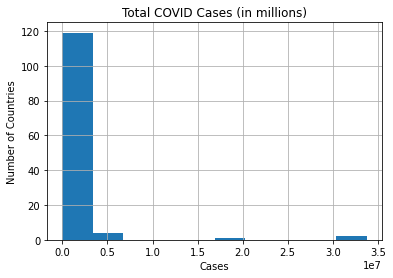

In [111]:
fig, ax = plt.subplots()
y_train.hist(ax=ax)
ax.set(
    title="Total COVID Cases (in millions)",
    xlabel="Cases",
    ylabel="Number of Countries",
)

^ This illustrates a very high skew for the total number of cases. In fact, it looks log-normal, which is not surprising given the large number of very low values and several very high values.

In [131]:
y_train_log = FunctionTransformer(np.log).fit_transform(y_train.total_cases)
y_train_log.skew()  # We have negative skew.

-1.3872728024141519

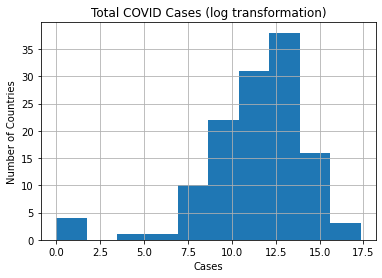

In [134]:
fig, ax = plt.subplots()
y_train_log.hist(ax=ax)
_ = ax.set(
    title="Total COVID Cases (log transformation)",
    xlabel="Cases",
    ylabel="Number of Countries",
)

In [143]:
y_train_boxcox = power_transform(y_train, method="box-cox")
y_train_boxcox = pd.DataFrame(
    y_train_boxcox, columns=["total_cases"], index=y_train.index
)
y_train_boxcox.total_cases.skew()

0.07333475786753518

[Text(0.5, 1.0, 'Total COVID Cases (Box-Cox transformation'),
 Text(0.5, 0, 'Cases'),
 Text(0, 0.5, 'Number of Countries')]

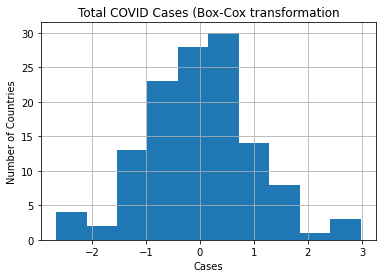

In [142]:
fig, ax = plt.subplots()
y_train_boxcox.total_cases.hist(ax=ax)
ax.set(
    title="Total COVID Cases (Box-Cox transformation",
    xlabel="Cases",
    ylabel="Number of Countries",
)

Box-Cox transformation identify a value for lambda between -5 and 5 and generates distribution that is closes to normal.

In [144]:
boxcox_lambda = stats.boxcox(y_train.total_cases)[1]
boxcox_lambda

0.10435377585681517

^ The lambda for the __Box-Cox__ transformation is 0.104. For comparison, the lambda for a feature with a Gaussian distribution would be 1.000, meaning that no transformation would be necessary.

## Feature Binning

Sometimes, we will want to convert a continuous feature into a categorical feature. The processing of creating _k_ equally spaced intervals from the minimum to the maximum value of a distribution is called __binning__ (or __discretization__).


Binning can address several important issues with a feature: skew, excessive kurtosis, and the presence of outliers.

### Equal-width and equal-frequency binning

In [168]:
import pandas as pd
from feature_engine.discretisation import EqualFrequencyDiscretiser as efd
from feature_engine.discretisation import EqualWidthDiscretiser as ewd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from data.load import load_covid

In [169]:
covid = load_covid()
feature_cols = [
    "location",
    "population",
    "aged_65_older",
    "diabetes_prevalence",
    "region",
]
covid = covid[["total_cases"] + feature_cols].dropna()
X_train, X_test, y_train, y_test = train_test_split(
    covid[feature_cols], covid[["total_cases"]], test_size=0.3, random_state=0
)

In [170]:
y_train["total_cases_group"] = pd.qcut(
    y_train.total_cases, q=10, labels=np.arange(0, 10)
)

In [171]:
y_train.total_cases_group.value_counts().sort_index()

0    13
1    13
2    12
3    13
4    12
5    13
6    12
7    13
8    12
9    13
Name: total_cases_group, dtype: int64

In [172]:
def run_transform(bt, train_df, test_df):
    bt.fit(train_df)
    train_bins = bt.transform(train_df)
    test_bins = bt.transform(test_df)
    return train_bins, test_bins

In [173]:
bin_transformer = efd()
y_train.drop(["total_cases_group"], axis=1, inplace=True, errors="ignore")
y_train_bins, y_test_bins = run_transform(bin_transformer, y_train, y_test)
y_train_bins.total_cases.value_counts().sort_index()

0    13
1    13
2    12
3    13
4    12
5    13
6    12
7    13
8    12
9    13
Name: total_cases, dtype: int64

^ This gives us the same result as `qcut`, but it has an advantage of being easier to bring into a machine learning pipeline.

In [174]:
bin_transformer = ewd(bins=10, variables=["total_cases"])
y_train_bins, y_test_bins = run_transform(bin_transformer, y_train, y_test)
y_train_bins.total_cases.value_counts().sort_index()

0    119
1      4
5      1
9      2
Name: total_cases, dtype: int64

^ This is a far less successful transformation. Almost all of the values are at the bottom of the distribution in the data prior to the binning, so it is not surprising that equal-width binning would have the same problem. It results in only 4 bins, even though we requested 10.

In [175]:
y_train_bins = y_train_bins.rename(columns={"total_cases": "total_cases_group"}).join(
    y_train
)
y_train_bins.groupby("total_cases_group")["total_cases"].agg(["min", "max"])

,min,max
total_cases_group,,
0,1.0,3304135.0
1,3740567.0,5856682.0
5,18909037.0,18909037.0
9,30709557.0,33770444.0


### K-means binning

When _k-means_ is used for binning, all data points in the same cluster will have the same ordinal value.

In [176]:
kbins = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="kmeans")
y_train_bins = pd.DataFrame(kbins.fit_transform(y_train), columns=["total_cases"])
y_train_bins.total_cases.value_counts().sort_index()

0.0    49
1.0    24
2.0    23
3.0    11
4.0     6
5.0     6
6.0     4
7.0     1
8.0     1
9.0     1
Name: total_cases, dtype: int64

In [177]:
y_train.total_cases.agg(["skew", "kurtosis"])

skew         6.313169
kurtosis    41.553054
Name: total_cases, dtype: float64

In [179]:
y_train_bins.total_cases.agg(["skew", "kurtosis"])

skew        1.439460
kurtosis    1.923158
Name: total_cases, dtype: float64

^ We expect a skew of 0 and a kurtosis near 3 for a variable with a Gaussian distribution. The distribution of the binned variable is much closer to Gaussian.

### Summary

Binning can help us to address skew, kurtosis, and outliers in our data. 

## Feature scaling

Often, the features we want to use in our model are on very different scales. Put simply, the distance between the minimum and maximum values, or the range, varies substantially across possible features.

Having features on very different scales impacts many machine learning algorithms. Scaling can address this problem.

Two popular approaches to scaling are __min-max scaling__ and __standard__ (or __z-score__) scaling. __Min-max scaling__ replaces each value with its location in the range.

__Standard scaling__ normalizes the feature values around a mean of 0.

In [181]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from data.load import load_covid

In [186]:
covid = load_covid()
feature_cols = [
    "population",
    "total_deaths",
    "aged_65_older",
    "diabetes_prevalence",
]
covid = covid[["total_cases"] + feature_cols].dropna()
X_train, X_test, y_train, y_test = train_test_split(
    covid[feature_cols], covid[["total_cases"]], test_size=0.3, random_state=0
)

In [187]:
scaler = MinMaxScaler()
X_train_mms = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_train_mms.describe()

,population,total_deaths,aged_65_older,diabetes_prevalence
count,123.000000,123.000000,123.000000,123.000000
mean,0.037236,0.044661,0.297696,0.411412
std,0.127555,0.142153,0.240547,0.225113
min,0.000000,0.000000,0.000000,0.000000
25%,0.002371,0.000730,0.096005,0.257621
50%,0.007174,0.003499,0.217140,0.371189
75%,0.022804,0.019308,0.505732,0.543335
max,1.000000,1.000000,1.000000,1.000000


In [188]:
scaler = StandardScaler()
X_train_ss = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_train_ss.describe()

,population,total_deaths,aged_65_older,diabetes_prevalence
count,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02
mean,-1.308800e-17,-1.263668e-17,-5.912163e-17,-2.888385e-17
std,1.004090e+00,1.004090e+00,1.004090e+00,1.004090e+00
min,-2.931128e-01,-3.154621e-01,-1.242640e+00,-1.835052e+00
25%,-2.744523e-01,-3.103063e-01,-8.418987e-01,-6.859660e-01
50%,-2.366417e-01,-2.907490e-01,-3.362588e-01,-1.794085e-01
75%,-1.135999e-01,-1.790797e-01,8.683824e-01,5.884261e-01
max,7.578731e+00,6.747961e+00,2.931548e+00,2.625321e+00


If we have outliers in our data, robust scaling might be a good option. Robust scaling substracts the median from each value of a variable and divides that value by the interquartile range:

$$z_{ij} = (x_{ij} - median_j)/(3rd quantile_j - 1st quantile_j)$$

Robust scaling is less sensitive to extreme values since it does not use the mean or variance.

In [189]:
scaler = RobustScaler()
X_train_rs = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_train_rs.describe()

,population,total_deaths,aged_65_older,diabetes_prevalence
count,123.000000,123.000000,123.000000,123.000000
mean,1.471173,2.215625,0.196610,0.140780
std,6.242306,7.651574,0.587091,0.787897
min,-0.351074,-0.188324,-0.529960,-1.299163
25%,-0.235064,-0.149034,-0.295647,-0.397490
50%,0.000000,0.000000,0.000000,0.000000
75%,0.764936,0.850966,0.704353,0.602510
max,48.587225,53.637825,1.910684,2.200837


## Summary

In this chapter, we covered a wide range of feature engineering techniques:

- tools to drop redundant or highly correlated feaures
- one-hot encoding, ordinal encoding and hashing encoding
- use transformation to improve distribution of our features
- common binning and scaling approaches to address skew, kurtosis, and outliers, and to adjust for features with widely different ranges